# Down-scaled multi-area model

#### Notebook structure <a class="anchor" id="toc"></a>
* [S0. Configuration](#section_0)
* [S1. Parameterization](#section_1)
    * [1.1. Parameters to tune](#section_1_1)
    * [1.2. Default parameters](#section_1_2)
* [S2. Multi-Area Model Instantiation and Simulation](#section_2)
    * [2.1. Insantiate a multi-area model](#section_2_1)
    * [2.2. Predict firing rates from theory](#section_2_2)
    * [2.3. Extract and visualize interareal connectivity](#section_2_3)
    * [2.4. Run a simulation](#section_2_4)
* [S3. Extract Interneural Connectivity](#section_3)
* [S4. Data Loading and Processing](#section_4)
* [S5. Simulation Results Visualziation](#section_5) 
    * [5.1. Instantaneous and mean firing rate across all populations](#section_5_1)
    * [5.2 Resting state plots](#section_5_2)
    * [5.3 Time-averaged population rates](#section_5_3)

## S0. Configuration <a class="anchor" id="section_0"></a>

In [1]:
# Create config file
with open('config.py', 'w') as fp:
    fp.write(
'''import os
base_path = os.path.abspath(".")
data_path = os.path.abspath("simulations")
jobscript_template = "python {base_path}/run_simulation.py {label}"
submit_cmd = "bash -c"
''')

In [2]:
%matplotlib inline
import numpy as np
import os
import nest
import json

from multiarea_model import MultiAreaModel
from config import base_path, data_path

import sys
sys.path.append('./figures/MAM2EBRAINS')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: May 17 2023 20:48:31

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
!pip install nested_dict dicthash

In [4]:
# Jupyter notebook display format setting
from IPython.display import display, HTML
style = """
<style>
table {float:left}
</style>
"""
display(HTML(style))

# Ignore and don't display warning messages
import warnings
warnings.filterwarnings("ignore")

Go back to [Notebook structure](#toc)

## S1. Parameterization <a class="anchor" id="section_1"></a>

### 1.1. Parameters to tune <a class="anchor" id="section_1_1"></a>

|Parameter                     |Default value            |Value range/options                                                   |Value assigned      |Description  |
|:----------------------------:|:-----------------------:|:--------------------------------------------------------------------:|:------------------:|:-----------:|
|scale_down_to                 |1.                       |(0, 1.0]                                                               |0.005               |$^1$         |
|cc_weights_factor             |1.                       |[1.0, 2.5]                                                               |1.                  |$^2$         |
|areas_simulated               |complete_area_list       |Sublists of complete_area_list                                     |complete_area_list  |$^3$         |
|replace_non_simulated_areas   |None                     |None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'   |'het_poisson_stat'  |$^4$         |

1. `scale_down_to` <br>
`scale_down_to` is the down-scaling factor which defines the the ratio of the full scale multi-area model being down-scaled to a model with fewer neurons and indegrees so as to be simulated on machines with lower computational ability and the simulation results can be obtained within relative shorter period of time. <br> Its deafualt value if `1.` meaning full scale simulation. <br> In the pre-set downscale version, it's set as `0.005`, where the numer of neurons and indegrees are both scaled down to 0.5% of its full scale amount, where the model can usually be simulated on a local machine. <br> **Warning**: This will not yield reasonable dynamical results from the network and is only meant to demonstrate the simulation workflow <br> 
2. `cc_weights_factor` <br>
This scaling factor controls the cortico-cortical synaptic strength. <br> By default it's set as `1.0`, where the inter-area synaptic strength is the same as the intra-areal. <br> **Important**: This factor changes the network activity from ground state to metastable state. <br>
3. `areas_simulated` <br>
This parameter specifies the cortical areas included in the simulation process. Its default value is `complete_area_list` meaning all the areas in the complete_area_list will be actually simulated. <br>
complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH'] <br>
The value assigned to simulation_areas can be any sublist of the compete_area_list specifying areas a user want to include in his/her simulation. <br>
4. `replace_non_simulated_areas` <br>
The paramter `replace_non_simulated_areas` defines how non-simulated areas will be replaced. <br> It's set as `None` by default when the parameter areas_simulated is set as full_area_list where all areas will be simulated so that no areas need to be replaced. <br> Other options are: `'hom_poisson_stat'`, `'het_poisson_stat'`, and `'het_current_nonstat'`. `'hom_poisson_stat'` is a manually set parameter which can be tuned. When it's set as 'het_poisson_stat' or 'het_current_nonstat', the data to replace the cortico-cortical input is loaded from 'replace_cc_input_source' which is the firing rates of our full scale simulation results. The differenc between 'het_poisson_stat' and 'het_current_nonstat' is that 'het_poisson_stat' is the mean of the time-series firing rate so that it's static, yet 'het_current_nonstat' is time-varying specific current, which is varying by time. 

In [5]:
# Downscaling factor
# Value range/options: (0, 1.]
# Value assgined: 0.005
scale_down_to = 0.005 # Change it to 1. for running the fullscale network

# Scaling factor for cortico-cortical connections (chi) 
# Value range/options: [1., 2.5]
# Value assgined: 1.0
cc_weights_factor = 1.0

# Cortical areas included in the simulation
# Value range/options: any sublist of complete_ares_list
# Value assgined: complete_ares_list
areas_simulated = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']

# Firing rates used to replace the non-simulated areas
# Value range/options: None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'
# Value assgined: 'het_poisson_stat'
replace_non_simulated_areas = 'het_poisson_stat'

### 1.2. Default parameters <a class="anchor" id="section_1_2"></a>
We try our best not to confuse users with too many parameters. However, if you want to change more parameters and explore the model, you can do so by passing a dictionary to the `default_params` argument of the `MultiAreaModel` class.

In [6]:
# Connection parameters
conn_params = {
    'replace_non_simulated_areas': 'het_poisson_stat', # Whether to replace non-simulated areas by Poisson sources with the same global rate, by default: None
    'g': -11., # It sets the relative inhibitory synaptic strength, by default: -16.
    'K_stable': 'K_stable.npy', # Whether to apply the stabilization method of Schuecker, Schmidt et al. (2017), by default: None
    'fac_nu_ext_TH': 1.2, # Increase the external input to 2/3E and 5E in area TH
    'fac_nu_ext_5E': 1.125, # Increase the external Poisson indegree onto 5E
    'fac_nu_ext_6E': 1.41666667, # Increase the external Poisson indegree onto 6E
    'av_indegree_V1': 3950. # Adjust the average indegree in V1 based on monkey data
}

# Input parameters
input_params = {
    'rate_ext': 10. # Rate of the Poissonian spike generator (in spikes/s)
} 

# Neuron parameters
neuron_params = {
    'V0_mean': -150., # Mean for the distribution of initial membrane potentials, by default: -100.
    'V0_sd': 50.} # Standard deviation for the distribution of initial membrane potentials, by default: 50.

# Network parameters
network_params = {
    'N_scaling': scale_down_to, # Scaling of population sizes, by default: 1.
    'K_scaling': scale_down_to, # Scaling of indegrees, by default: 1.
    'fullscale_rates': 'tests/fullscale_rates.json', # Absolute path to the file holding full-scale rates for scaling synaptic weights, by default: None
    'input_params': input_params, # Input parameters
    'connection_params': conn_params, # Connection parameters
    'neuron_params': neuron_params # Neuron parameters
} 

# Simulation parameters
sim_params = {
    'areas_simulated': areas_simulated,
    't_sim': 2000., # Simulated time (in ms), by default: 10.0
    # 't_sim': 1500., # Simulated time (in ms), by default: 10.0
    'num_processes': 1, # The number of MPI processes, by default: 1
    'local_num_threads': 1, # The number of threads per MPI process, by default: 1
    'recording_dict': {'record_vm': False},
    'rng_seed': 1  # global random seed
}

# Theory paramters (theory_params)
theory_params = {
    'dt': 0.1 # The time step of the mean-field theory integration, by default: 0.01
} 

Go back to [Notebook structure](#toc)

## S2. Multi-Area Model Instantiation and Simulation <a class="anchor" id="section_2"></a>

### 2.1. Insantiate a multi-area model <a class="anchor" id="section_2_1"></a>

In [7]:
M = MultiAreaModel(network_params, 
                   simulation=True,
                   sim_spec=sim_params,
                   theory=True,
                   theory_spec=theory_params)

Initializing network from dictionary.
RAND_DATA_LABEL 4498


Error in library("aod") : there is no package called ‘aod’
Execution halted


No R installation or IndexError, taking hard-coded SLN fit parameters.


Customized parameters
--------------------
{'K_scaling': 0.005,
 'N_scaling': 0.005,
 'connection_params': {'K_stable': 'K_stable.npy',
                       'av_indegree_V1': 3950.0,
                       'fac_nu_ext_5E': 1.125,
                       'fac_nu_ext_6E': 1.41666667,
                       'fac_nu_ext_TH': 1.2,
                       'g': -11.0,
                       'replace_non_simulated_areas': 'het_poisson_stat'},
 'fullscale_rates': 'tests/fullscale_rates.json',
 'input_params': {'rate_ext': 10.0},
 'neuron_params': {'V0_mean': -150.0, 'V0_sd': 50.0}}
Simulation label: 27d81076e6d6e9e591684be053078477
Copied files.
Initialized simulation class.


### 2.2. Predict firing rates from theory <a class="anchor" id="section_2_2"></a>

In [8]:
p, r = M.theory.integrate_siegert()
print("Mean-field theory predicts an average "
      "firing rate of {0:.3f} spikes/s across all populations.".format(np.mean(r[:, -1])))

Iteration: 0
Mean-field theory predicts an average firing rate of 29.588 spikes/s across all populations.


### 2.3. Extract and visualize interareal connectivity <a class="anchor" id="section_2_3"></a>

The connectivity and neuron numbers are stored in the attributes of the model class. Neuron numbers are stored in `M.N` as a dictionary (and in `M.N_vec` as an array), indegrees in `M.K` as a dictionary (and in `M.K_matrix` as an array). Number of synapses can also be access via `M.synapses` (and in `M.syn_matrix` as an array). <br>

In [9]:
# Indegrees
# Dictionary of nodes indegrees organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: indegree_values}}}}
# M.K

In [10]:
# Synapses
# Dictionary of synapses that target neurons receive, it is organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: number_of_synapses}}}}
# M.synapses

Go back to [Notebook structure](#toc)

### 2.4. Run a simulation <a class="anchor" id="section_2_4"></a>

In [11]:
# run the simulation, depending on the model parameter and downscale ratio, the running time varies largely.
M.simulation.simulate()

Prepared simulation in 0.00 seconds.
Rank 0: created area V1 with 0 local nodes
Memory after V1 : 1911.43 MB
Rank 0: created area V2 with 0 local nodes
Memory after V2 : 1938.14 MB
Rank 0: created area VP with 0 local nodes
Memory after VP : 1967.32 MB
Rank 0: created area V3 with 0 local nodes
Memory after V3 : 1995.58 MB
Rank 0: created area V3A with 0 local nodes
Memory after V3A : 2015.40 MB
Rank 0: created area MT with 0 local nodes
Memory after MT : 2041.07 MB
Rank 0: created area V4t with 0 local nodes
Memory after V4t : 2066.01 MB
Rank 0: created area V4 with 0 local nodes
Memory after V4 : 2092.96 MB
Rank 0: created area VOT with 0 local nodes
Memory after VOT : 2118.31 MB
Rank 0: created area MSTd with 0 local nodes
Memory after MSTd : 2139.74 MB
Rank 0: created area PIP with 0 local nodes
Memory after PIP : 2161.10 MB
Rank 0: created area PO with 0 local nodes
Memory after PO : 2182.56 MB
Rank 0: created area DP with 0 local nodes
Memory after DP : 2202.79 MB
Rank 0: created

Go back to [Notebook structure](#toc)

## S3. Extract Interneural Connectivity <a class="anchor" id="section_3"></a>

**Warning**: Memory explosion <br>
To obtain the connections information, you can extract the lists of connected sources and targets. Moreover, you can access additional synaptic details, such as synaptic weights and delays.

In [12]:
# conns = nest.GetConnections()
# conns_sparse_matrix = conns.get(['source', 'target', 'weight'])

# srcs = conns_sparse_matrix['source']
# tgts = conns_sparse_matrix['target']
# weights = conns_sparse_matrix['weight']

You can determine the area and subpopulation to which the neuron ID ranges belong by referring to the file `network_gids.txt`, which is automatically generated during network creation.

In [13]:
# # Open the file using a with statement
# with open(os.path.join(M.simulation.data_dir,"recordings/network_gids.txt"), "r") as file:
#     # Read the contents of the file
#     gids = file.read()

# # Print the contents
# print(gids)

Go back to [Notebook structure](#toc)

## S4. Data Loading and Processing <a class="anchor" id="section_4"></a>

In [14]:
label_spikes = M.simulation.label
label = M.simulation.label

from MAM2EBRAINS_LOAD_DATA import load_data
A, tsteps, firing_rate = load_data(M)

loading spikes
Loading data from file
Computing population rates done
Loading data from file
Computing synchrony done
Loading data from file
Computing population LvR done
Loading data from file
Loading data from file
Computing rate time series done
pop_LvR
pop_rates
synchrony


Go back to [Notebook structure](#toc)

## S5. Simulation Results Visualziation <a class="anchor" id="section_5"></a>

### 5.1. Instantaneous and mean firing rate across all populations <a class="anchor" id="section_5_1"></a>

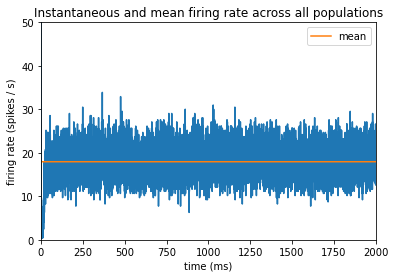

In [15]:
from MAM2EBRAINS_VISUALIZATION import plot_instan_mean_firing_rate
plot_instan_mean_firing_rate(tsteps, firing_rate, sim_params)

### 5.2 Resting state plots <a class="anchor" id="section_5_2"></a>

**Fig 5. Resting state of the model with χ =1.9.** (A-C) Raster plot of spiking activity of 3% of the neurons in area V1 (A), V2 (B), and FEF (C). Blue: excitatory neurons, red: inhibitory neurons. (D-F) Spiking statistics across all 32 areas for the respective populations shown as area-averaged box plots. Crosses: medians, boxes: interquartile range (IQR), whiskers extend to the most extremeobservat ions within 1.5×IQR beyond the IQR. (D) Population-averaged firing rates. (E) Average pairwise correlation coefficients of spiking activity. (F) Irregularity measured by revised local variation LvR averaged across neurons. (G) Area-averaged firing rates, shown as raw binned spike histograms with 1ms bin width (gray) and convolved histograms, with aGaussian kernel (black) of optimal width.

Initializing network from dictionary.
RAND_DATA_LABEL 3481


Error in library("aod") : there is no package called ‘aod’
Execution halted


No R installation or IndexError, taking hard-coded SLN fit parameters.


Customized parameters
--------------------
{}


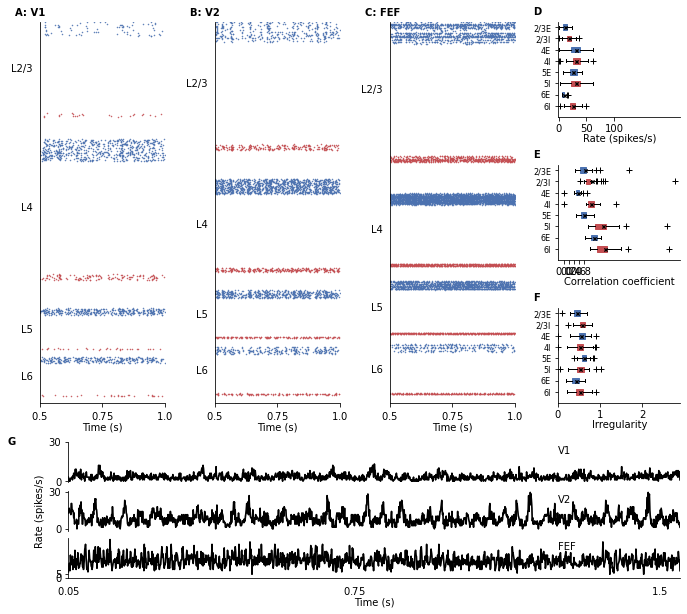

In [16]:
from MAM2EBRAINS_VISUALIZATION import plot_resting_state
plot_resting_state(A, label_spikes, data_path, sim_params)

### 5.3 Time-averaged population rates <a class="anchor" id="section_5_3"></a>
Plot overview over time-averaged population rates encoded in colors with areas along x-axis and populations along y-axis.

0 V1
1 V2
2 VP
3 V3
4 PIP
5 V3A
6 MT
7 V4t
8 V4
9 PO
10 VOT
11 DP
12 MIP
13 MDP
14 MSTd
15 VIP
16 LIP
17 PITv
18 PITd
19 AITv
20 MSTl
21 FST
22 CITv
23 CITd
24 7a
25 STPp
26 STPa
27 FEF
28 46
29 TF
30 TH
31 AITd
['23E', '23I', '4E', '4I', '5E', '5I', '6E', '6I']


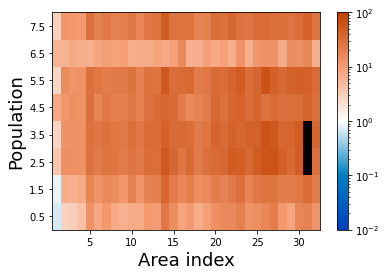

In [17]:
# area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']
# output = {'pdf', 'png', 'eps'}, optional
A.show_rates()

Go back to [Notebook structure](#toc)